In [280]:
import mne
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from mne.preprocessing import ICA
%matplotlib inline

Import data and store in pandas dataframe

In [281]:
#eeg_data = pd.read_csv('5_blinks_2.csv')
eeg_data = pd.read_csv('closed_relaxed_2.csv')

We've stored timestamps (every 1/256th of a second) and voltage values for each electrode at each timestamp. Let's look at it:

In [282]:
eeg_data
start_step = 0
end_step = len(eeg_data)

This data was recorded without any 'AUX' electrode, so let's delete the meaningless data. The timestamp is also arbitrary, so let's normalize it. 

In [283]:
del eeg_data['Right AUX']
eeg_data['timestamps'] -= eeg_data['timestamps'][0]
eeg_data

,timestamps,TP9,AF7,AF8,TP10
0,0.000,39.062,41.992,33.691,41.016
1,0.004,36.133,41.504,29.785,37.598
2,0.008,39.062,37.109,29.785,42.480
3,0.012,29.785,33.203,22.461,36.133
4,0.016,20.996,31.738,15.137,23.438
5,0.020,20.508,32.227,13.672,21.484
6,0.024,23.926,31.738,14.648,25.879
7,0.028,30.273,37.109,14.648,31.738
8,0.031,24.414,40.039,9.766,30.762
9,0.035,23.438,35.156,6.836,23.926


Note that we could also have specified the columns we wanted to read in the csv_read() function with the param 'usecols'

In [284]:
#space out plots
channels = ['TP9','TP10','AF7','AF8']
adjust = np.arange(0,400,100) #space out the channels
eeg_data_for_plot = eeg_data # make a copy for plot
eeg_data_for_plot.loc[:,channels] += adjust

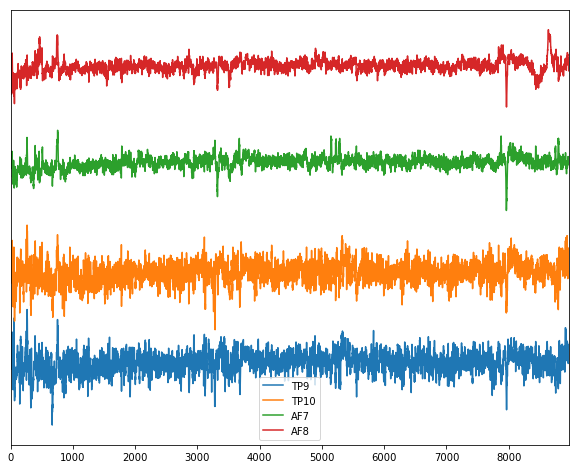

In [285]:
plt.rcParams['figure.figsize'] = [10, 8]
eeg_data_for_plot.loc[start_step:end_step,channels].plot()
plt.yticks([]);

Ok, we can clearly see the 5 blinks... Now to remove them with mne!

First we convert the channel data to a raw numpy array

In [286]:
raw_data = eeg_data.loc[:,channels]
raw_data = raw_data.values
raw_data = raw_data[start_step:end_step,:]

In [287]:
sfreq = 256  # Hz
channel_types = ['eeg', 'eeg', 'eeg' , 'eeg']
ch_names = channels
# convert to volts for mne
raw_data *= 0.000001
# Create the info structure needed by MNE
info = mne.create_info(ch_names, sfreq, channel_types)
# Finally, create the Raw object
raw = mne.io.RawArray(raw_data.T, info)
montage = mne.channels.read_montage('standard_1020',ch_names=['TP9','TP10','AF7','AF8'])
raw.set_montage(montage)
# 1Hz high pass is often helpful for fitting ICA
raw.filter(1., 100.)

Creating RawArray with float64 data, n_channels=4, n_times=8964
    Range : 0 ... 8963 =      0.000 ...    35.012 secs
Ready.
Setting up band-pass filter from 1 - 1e+02 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 25.0 Hz
Filter length of 1690 samples (6.602 sec) selected


<RawArray  |  None, n_channels x n_times : 4 x 8964 (35.0 sec), ~292 kB, data loaded>

Note that the data can be recovered from this raw mne object at any time like so:

In [288]:
data, times = raw[:]
data.shape

(4, 8964)

In [289]:
# 4 components chosen arbitrarily.. can't do more than # channels
ica = ICA(n_components=4,method='fastica')
# tell mne what kind of data it's dealing with
picks_eeg = mne.pick_types(raw.info, meg=False, eeg=True, eog=False)
# fit the components
ica.fit(raw, picks=picks_eeg)

Fitting ICA to data using 4 channels. 
Please be patient, this may take some time
Inferring max_pca_components from picks.
Selection by number: 4 components


<ICA  |  raw data decomposition, fit (fastica): 8964 samples, 4 components, channels used: "eeg">

Now plot the components.. we can clearly see the 5 blinks in component 0

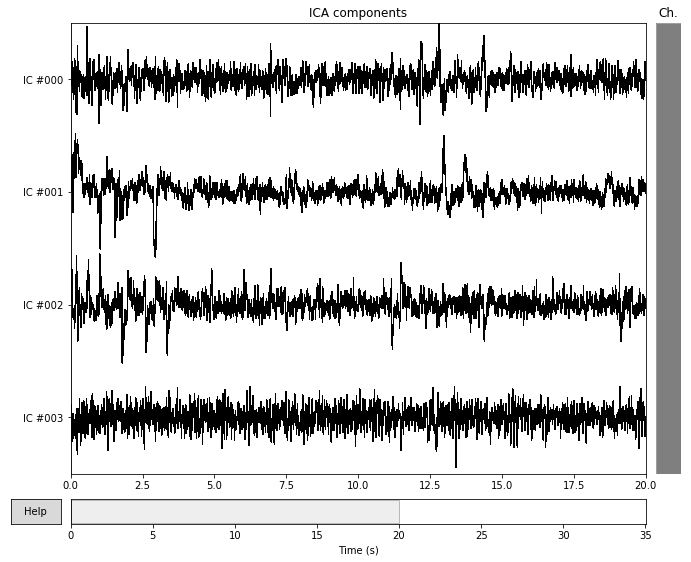

In [290]:
ica.plot_sources(raw);

Now we use the apply method to exlude that component and reconstruct the signal

In [291]:
clean_data = ica.apply(raw, exclude=[0])

Transforming to ICA space (4 components)
Zeroing out 1 ICA components


In [292]:
data, times = clean_data[:]
# convert from volts 
data /= 0.000001
print(np.shape(times))
print(np.shape(data))

(8964,)
(4, 8964)


Let's plot the clean data!

In [293]:
eeg_data_clean = pd.DataFrame(data.T,columns=channels)
eeg_data_clean_plot = eeg_data_clean # make a copy for plot
eeg_data_clean_plot.loc[:,channels] += adjust

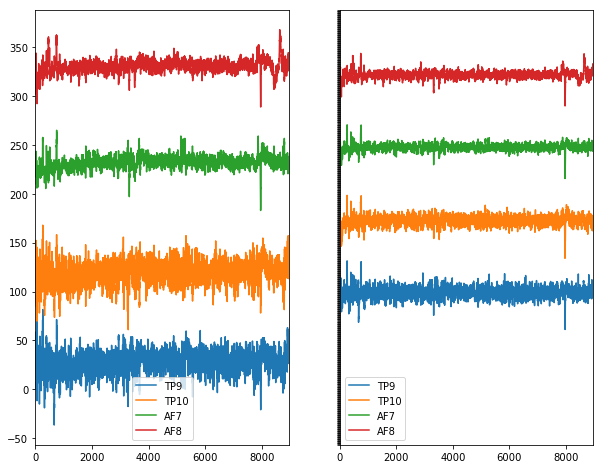

In [294]:
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.rcParams['figure.figsize'] = [10, 8]
eeg_data_for_plot.loc[start_step:end_step,channels].plot(ax=axes[0])
eeg_data_clean_plot.loc[:,channels].plot(ax=axes[1])
plt.yticks(np.arange(-225,425,1),[]); #idk how to plot